# Machine Learning - Practical 4 - Deep Learning VS Trees


* Names: Debwashis Borman, Navya Anantha Lakshmi Saginala, Theint Hay Thi Maung
* Summer Term 2023   
* Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [8]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [9]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [10]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('/kaggle/input/road-safety/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [11]:
dataset

Accident_Index  Vehicle_Reference_df_res  Vehicle_Type  \
0       201501BS70001                         1          19.0   
1       201501BS70002                         1           9.0   
2       201501BS70004                         1           9.0   
3       201501BS70005                         1           9.0   
4       201501BS70008                         1           1.0   
...               ...                       ...           ...   
363238  2015984141415                        13           9.0   
363239  2015984141415                        13           9.0   
363240  2015984141415                        13           9.0   
363241  2015984141415                        13           9.0   
363242  2015984141415                        13           9.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
0                           0.0                9.0   
1                           0.0                9.0   
2                           0.0                9.0   
3                           0.0                9.0   
4                           0.0               18.0   
...                         ...                ...   
363238                      0.0               18.0   
363239                      0.0               18.0   
363240                      0.0               18.0   
363241                      0.0               18.0   
363242                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                    0.0                8.0   
1                                    0.0                8.0   
2                                    0.0                2.0   
3                                    0.0                2.0   
4                                    0.0                8.0   
...                                  ...                ...   
363238                               0.0                0.0   
363239                               0.0                0.0   
363240                               0.0                0.0   
363241                               0.0                0.0   
363242                               0.0                0.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
363238                       0.0                        0.0   
363239                       0.0                        0.0   
363240                       0.0                        0.0   
363241                       0.0                        0.0   
363242                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  ...  Age_Band_of_Casualty  \
0                               0.0  ...                   7.0   
1                               0.0  ...                   5.0   
2                               0.0  ...                   6.0   
3                               0.0  ...                   2.0   
4                               0.0  ...                   8.0   
...                             ...  ...                   ...   
363238                          5.0  ...                   1.0   
363239                          5.0  ...                   5.0   
363240                          5.0  ...                   4.0   
363241                          5.0  ...                   6.0   
363242                          5.0  ...                   4.0   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
0                       3                  5.0                  1.0   
1                       3                  9.0                  9.0   
2                       3                  1.0           

In [12]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [13]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    #TODO
    df = df.dropna()
    return df
    


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    # TODO
    for col in df.columns:
        if df[col].nunique() <= n and col not in ignore:
            df[col] = df[col].astype('category')
    return df

    


def remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    if direction == 'less':
        for col in df.select_dtypes(include=[condition]).columns:
            if df[col].nunique() < n and col not in ignore:
                df = df.drop(col, axis=1)
    elif direction == 'more':
        for col in df.select_dtypes(include=[condition]).columns:
            if df[col].nunique() > n and col not in ignore:
                df = df.drop(col, axis=1)
    return df

In [14]:
df = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less', 
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more', 
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

/tmp/ipykernel_28/2529332743.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
/tmp/ipykernel_28/2529332743.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype('category')
/tmp/ipykernel_28/2529332743.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [15]:
df

Vehicle_Type  Vehicle_Manoeuvre  Vehicle_Location-Restricted_Lane  \
2                9.0                9.0                               0.0   
6                3.0               18.0                               0.0   
7               19.0                6.0                               0.0   
8                9.0                9.0                               0.0   
12               9.0               13.0                               0.0   
...              ...                ...                               ...   
328127           9.0                5.0                               0.0   
328128           9.0               18.0                               0.0   
328129           9.0               18.0                               0.0   
328130           9.0                3.0                               0.0   
328131           9.0                3.0                               0.0   

        Hit_Object_in_Carriageway  Hit_Object_off_Carriageway  \
2                             0.0                         0.0   
6                             0.0                         0.0   
7                             0.0                         0.0   
8                             0.0                         0.0   
12                            0.0                         0.0   
...                           ...                         ...   
328127                        0.0                         0.0   
328128                        0.0                         0.0   
328129                        0.0                         0.0   
328130                        0.0                         0.0   
328131                        0.0                         0.0   

       Was_Vehicle_Left_Hand_Drive? Sex_of_Driver  Age_of_Driver  \
2                               1.0           1.0           30.0   
6                               1.0           1.0           37.0   
7                               1.0           1.0           44.0   
8                               1.0           1.0           37.0   
12                              1.0           2.0           39.0   
...                             ...           ...            ...   
328127                          1.0           2.0           75.0   
328128                          1.0           1.0           18.0   
328129                          1.0           1.0           18.0   
328130                          1.0           2.0           43.0   
328131                          1.0           2.0           43.0   

        Age_Band_of_Driver  Engine_Capacity_(CC)  ...  2nd_Road_Number  \
2                      6.0                1686.0  ...              0.0   
6                      7.0                 124.0  ...              0.0   
7                      7.0                2402.0  ...              0.0   
8                      7.0                1461.0  ...           3218.0   
12                     7.0                1248.0  ...              0.0   
...                    ...                   ...  ...              ...   
328127                10.0                 996.0  ...              0.0   
328128                 4.0                1796.0  ...              0.0   
328129                 4.0                1796.0  ...              0.0   
328130                 7.0                1590.0  ...              0.0   
328131                 7.0                1590.0  ...              0.0   

        Urban_or_Rural_Area  Casualty_Reference  Sex_of_Casualty  \
2                       1.0                   1              2.0   
6                       1.0                   1              1.0   
7                       1.0                   1              1.0   
8                       1.0                   1              1.0   
12                      1.0                   1              1.0   
...                     ...                 ...              ...   
328127                  1.0                   2              2.0   
328128                  1.0                   1     

In [16]:
df[target_column]

2         1.0
6         1.0
7         1.0
8         1.0
12        2.0
         ... 
328127    2.0
328128    1.0
328129    1.0
328130    2.0
328131    2.0
Name: Sex_of_Driver, Length: 96326, dtype: category
Categories (3, object): ['1.0', '2.0', '3.0']

In [17]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)

In [18]:
X.shape

(96326, 28)

In [19]:
print(f"Number of unique values in response variable: {Y.nunique()}")

Number of unique values in response variable: 3


In [20]:
train_y.shape

(77060,)

In [21]:
print("Original:", Y.value_counts(normalize=True))   # Normalize=True gives proportions
print("Train:", train_y.value_counts(normalize=True))
print("Test:", test_y.value_counts(normalize=True))


Original: 1.0    0.654776
2.0    0.343635
3.0    0.001588
Name: Sex_of_Driver, dtype: float64
Train: 1.0    0.654775
2.0    0.343641
3.0    0.001583
Name: Sex_of_Driver, dtype: float64
Test: 1.0    0.654780
2.0    0.343611
3.0    0.001609
Name: Sex_of_Driver, dtype: float64


**TODO :**  

* Did you split the dataset in a stratified manner or not? Why? - Yes. Stratified sampling ensures that each subset of the data retains the same proportions of the different classes as in the original dataset. This is important in cases where the target variable classes are imbalanced. Stratified sampling can provide more reliable and robust results, as it preserves the class distribution in both training and test datasets.
* How did the dataset dimensions change after preprocessing?Before- 363243 rows × 67 columns, After - 96326 rows × 29 columns 
* How many unique values are in the response variable? - 3

## Task 1: Create a GradientBoostingClassifier

In [22]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set

# define the model
model = GradientBoostingClassifier(random_state=random_state)

# train the model
model.fit(train_X, train_y)

# predict on the test set
predictions = model.predict(test_X)

In [23]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
# Compute accuracy
accuracy = accuracy_score(test_y, predictions)
print(f"Accuracy: {accuracy}")

# compute precision
precision = precision_score(test_y, predictions, average='weighted')
print(f"Precision: {precision}")

# compute recall
recall = recall_score(test_y, predictions, average='weighted')
print(f"Recall: {recall}")

Accuracy: 0.771981729471608
Precision: 0.76613570969081
Recall: 0.771981729471608


In [24]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    #TODO
    for n in trees_amount:
        # define and train the model
        model = GradientBoostingClassifier(n_estimators=n, random_state=random_state)
        model.fit(train_X, train_y)

        # predict on the test set
        predictions = model.predict(test_X)

        # compute and print accuracy, precision, and recall
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"For {n} trees:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}\n")


In [25]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For 1 trees:
Accuracy: 0.6548323471400395
Precision: 0.429596993052783
Recall: 0.6548323471400395

For 20 trees:
Accuracy: 0.7538669158102357
Precision: 0.7466889293442244
Recall: 0.7538669158102357

For 50 trees:
Accuracy: 0.7648188518633863
Precision: 0.7582964291668114
Recall: 0.7648188518633863

For 100 trees:
Accuracy: 0.771981729471608
Precision: 0.76613570969081
Recall: 0.771981729471608



In [26]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    #TODO
        for rate in learning_rates:
        # Define and train the model
            model = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=rate, random_state=random_state)
            model.fit(train_X, train_y)

            # predict on the test set
            predictions = model.predict(test_X)

            # compute and print accuracy, precision, and recall
            accuracy = accuracy_score(test_y, predictions)
            precision = precision_score(test_y, predictions, average='weighted')
            recall = recall_score(test_y, predictions, average='weighted')

            print(f"For learning rate {rate}:")
            print(f"Accuracy: {accuracy}")
            print(f"Precision: {precision}")
            print(f"Recall: {recall}\n")

In [27]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

For learning rate 0.1:
Accuracy: 0.771981729471608
Precision: 0.76613570969081
Recall: 0.771981729471608

For learning rate 0.2:
Accuracy: 0.776808886120627
Precision: 0.7719422592796077
Recall: 0.776808886120627

For learning rate 0.3:
Accuracy: 0.7774836499532856
Precision: 0.7716592940277175
Recall: 0.7774836499532856

For learning rate 0.4:
Accuracy: 0.7813765182186235
Precision: 0.7761171905097084
Recall: 0.7813765182186235

For learning rate 0.5:
Accuracy: 0.777224125402263
Precision: 0.7725434171762171
Recall: 0.777224125402263



In [28]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    # TODO
    for depth in depths:
        # Define and train the model
        model = GradientBoostingClassifier(max_depth=depth, random_state=random_state)
        model.fit(train_X, train_y)

        # predict on the test set
        predictions = model.predict(test_X)

        # compute and print accuracy, precision, and recall
        accuracy = accuracy_score(test_y, predictions)
        precision = precision_score(test_y, predictions, average='weighted')
        recall = recall_score(test_y, predictions, average='weighted')

        print(f"For max depth {depth}:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}\n")

In [29]:
max_depth_exploration(train_X, train_y, test_X, test_y)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For max depth 1:
Accuracy: 0.7476902314958995
Precision: 0.7385862260576793
Recall: 0.7476902314958995

For max depth 2:
Accuracy: 0.7543340600020761
Precision: 0.7463713497249382
Recall: 0.7543340600020761

For max depth 3:
Accuracy: 0.771981729471608
Precision: 0.76613570969081
Recall: 0.771981729471608

For max depth 5:
Accuracy: 0.7887470154676632
Precision: 0.784680035326936
Recall: 0.7887470154676632



**TODO :**   

* How does the max_depth parameter influence the results?-  Depth increase and so does the improvement of result. 
* How does the learning rate influence the results? - 0.4 is the best learning rate, for others model perform average. 
* How does the number of trees in the ensemble influence the results?- Increased amount of trees improve the result significantly.
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform? - Best parameters determined by Gridsearch - {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
0.7867116252306091

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [20, 50, 100],
    'max_depth': [1, 2, 3, 5]
}

# Initialize the classifier
clf = GradientBoostingClassifier(random_state=random_state)

# initialize grid search
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')

# fit the grid search to data
grid_search.fit(train_X, train_y)

# print the best parameters
print(grid_search.best_params_)

# print the accuracy of the best model
print(grid_search.best_score_)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
0.7867116252306091


In [32]:
clf = GradientBoostingClassifier(learning_rate=0.3, max_depth=5, n_estimators=100, random_state=random_state)

In [33]:
clf.fit(train_X, train_y)

GradientBoostingClassifier(learning_rate=0.3, max_depth=5, random_state=42)

In [34]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # TODO
    # Get feature importances
    importances = clf.feature_importances_

    # Create a dataframe for visualization
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })
    
    # Sort the dataframe by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10,8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature importances')
    plt.show()
    

In [35]:
## TODO : display the plot
plot_explained_variance(clf, train_X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [36]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return float(correct)/total

In [37]:
import fastprogress
import time

In [38]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 

## TODO: Define a train and validation functions here
## Hint - you can use yours from Practical 2 



def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """

    # TODO: refine the training function from above
  # it should contain:
  # - saving of losses
  # - calculation of accuracy
  # - returning the mean loss and accuracy
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # forward pass
        y_pred = model(x.float().to(device))

        # for calculating the accuracy, save the number of correctly classified 
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    # TODO: write a validation function that calculates the loss and accuracy on the validation set
    # you can also combine it with the training function
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)    

    model.eval()
    with torch.no_grad():
        for x, y in fastprogress.progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.float().to(device))

            # For calculating the accuracy, save the number of correctly 
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy 
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)
    

In [39]:
#TODO: write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from Practical 2 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # TODO: write a run_training function that 
 
    start_time = time.time()
    master_bar = fastprogress.master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [],[],[],[]

    for epoch in master_bar:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model, 
                                                  loss_function, device, master_bar)
        # Validate the model
        epoch_val_loss, epoch_val_acc= validate(val_dataloader, 
                                                                   model, loss_function, 
                                                                   device, master_bar)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        
        master_bar.write(f'Train loss: {epoch_train_loss:.2f}, val loss: {epoch_val_loss:.2f}, train acc: {epoch_train_acc:.3f}, val acc {epoch_val_acc:.3f}')

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs


In [40]:
# TODO write a plot function 
## Hint - you can use yours from practical 2 or 3 
def plot(title, label, train_results, val_results, yscale='linear'):
    """Plot learning curves.

    Args:
        title (str): Title of plot
        label (str): y-axis label
        train_results (list): Training results vector of length of number of epochs. Could be loss or accuracy.
        val_results (list): Validation results vector of length of number of epochs. Could be loss or accuracy.
        yscale (str, optional): plt.yscale parameter. Defaults to 'linear'.
    """
    epochs = range(1, len(train_results) + 1)
    
    sns.set(style='ticks')
    plt.plot(epochs, train_results, '--o', label='Training Results' )
    plt.plot(epochs, val_results, '--o', label='Validation Results')

    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.yscale(yscale)
    plt.title(title)
    plt.legend()

    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    
    plt.show()
# plot('Training and Validation Loss', 'Loss', train_losses, val_losses)

### Convert a pandas dataframe to a PyTorch dataset

In [41]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        self.x = df_x.to_numpy()
        self.y = df_y.to_numpy()
        
        if normalise:
            if mean is None:
                mean = self.x.mean()
            if std is None:
                std = self.x.std()
        
        self.mean = mean.to_numpy()
        self.std = std.to_numpy()
        self.normalise = normalise
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.x)
    
    def __getitem__(self, index):
        #  X and y by index
        x = self.x[index]
        y = self.y[index]
        # print(f"Shape of data point: {x.shape}")
        # print(f"Length of mean vector: {len(self.mean)}")
        # print(f"Length of std vector: {len(self.std)}")
        # Normalize if needed
        if self.normalise:
            x = (x - self.mean) / self.std
        
        return torch.from_numpy(x), torch.tensor(y, dtype=torch.long)

In [42]:
train_X.shape

(77060, 28)

In [43]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer
# Select only numeric columns
# numeric_columns = train_X.select_dtypes(include=np.number).columns

# # Calculate mean and std
# mean = train_X[numeric_columns].mean(axis=0)
# std = train_X[numeric_columns].std(axis=0)
# Convert categorical variables to numerical
train_X_numerical = pd.get_dummies(train_X)
mean = train_X_numerical.mean(axis=0)
std = train_X_numerical.std(axis=0)

print("shape of mean:", train_X_numerical.shape)
# print("Mean:", mean)
# print("Standard deviation:", std)


shape of mean: (77060, 31)


In [44]:
train_y.dtype

CategoricalDtype(categories=['1.0', '2.0', '3.0'], ordered=False)

In [45]:
train_y_int = train_y.astype('float').astype('int')
print(train_y_int.shape)
test_y_int = test_y.astype('float').astype('int')

(77060,)


In [46]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0!
train_s, val_s, train_t, val_t = train_test_split(train_X_numerical, train_y_int, test_size=0.2, random_state=42, stratify=train_y_int)

#  PyTorch does expect labels to be 0-based, we subtract 1 from the target values.
train_v = train_t - 1
val_v = val_t - 1
test_v = test_y_int - 1

#  datasets
train_dataset = TabularDataset(train_s, train_v, mean, std, normalise=True)
val_dataset = TabularDataset(val_s, val_v, mean, std, normalise=True)
test_dataset = TabularDataset(test_X, test_v, mean, std, normalise=True)


## TODO : define dataloaders, with specified batch size and shuffled
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [47]:
#  one batch of data
data, labels = next(iter(train_loader))

#  shapes
print('Data shape:', data.shape)
print('Labels shape:', labels.shape)

#  first data point and label
print('First data point:', data[0])
print('First label:', labels[0])



Data shape: torch.Size([256, 31])
Labels shape: torch.Size([256])
First data point: tensor([-1.1107,  1.0034, -0.0871, -0.1855, -0.2139, -1.2105, -1.1084, -1.1785,
        -1.4471, -0.4430, -0.1135, -0.4449, -0.1056, -0.0183, -0.6772,  0.2993,
         1.5437, -0.4039, -0.4931, -0.8992, -0.6864, -0.2185, -0.1812, -0.7786,
         0.0613,  0.0378, -0.0378,  0.6206, -0.6206,  0.8675, -0.8675],
       dtype=torch.float64)
First label: tensor(0)


In [48]:
# first 5 entries from train dataset
for i in range(5):
    data, label = train_dataset[i]
    print(f"Data: {data}, Label: {label}")


Data: tensor([-0.0740,  0.8364, -0.0871, -0.1855, -0.2139, -0.1590,  0.0433, -0.1424,
        -1.0370, -1.1334,  0.5063, -1.1525,  0.5102, -0.7756, -0.6772, -0.6440,
        -0.3033, -0.4039, -0.4931, -1.0644, -1.1553, -0.2185, -0.1812, -0.6178,
        -1.3593,  0.0378, -0.0378, -1.6113,  1.6113,  0.8675, -0.8675],
       dtype=torch.float64), Label: 1
Data: tensor([ 0.2716, -1.1665, -0.0871, -0.1855, -0.2139, -0.6538, -0.5326,  3.4460,
        -1.0370,  0.9808, -0.8533,  0.9674, -0.8559, -1.1251, -0.6772, -1.1662,
        -0.3081, -0.4039, -0.4931, -1.5048, -2.0930, -0.2185, -0.1812,  0.5074,
         0.0613,  0.0378, -0.0378,  0.6206, -0.6206,  0.8675, -0.8675],
       dtype=torch.float64), Label: 0
Data: tensor([-0.0740,  1.0034, -0.0871, -0.1855, -0.2139,  1.3874,  1.1951, -0.5637,
        -1.4471, -1.0122,  1.0641, -1.0338,  1.0663, -0.9503,  0.0717, -0.9584,
        -0.5731, -0.4039,  0.6216, -2.0553, -2.5619, -0.2185, -0.1812,  0.1859,
         1.1268,  0.0378, -0.0378, -1.6113

## Logistic regression

In [49]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.linear = torch.nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        # TODO run the data through the layer
        outputs = self.linear(x)
        return outputs

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)

Using device cuda


In [51]:
## TODO define model, loss and optimisers
## don't forget to move everything for the correct devices
## 
lr=0.001
input_dim = train_s.shape[1] # Number of features
output_dim = len(train_t.unique()) # Number of unique labels

#  model
model = LR(input_dim, output_dim)
model = model.to(device)
loss = torch.nn.CrossEntropyLoss()

# Optimizer (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [52]:
model.train()

LR(
  (linear): Linear(in_features=31, out_features=3, bias=True)
)

In [53]:
## TODO train the network
num_epochs = 30
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr = run_training(model, optimizer, loss, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)

Finished training after 75 seconds.


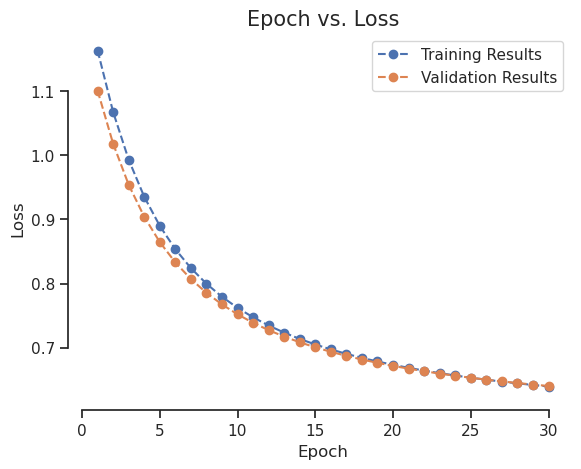

In [54]:
## todo - plot losses and accuracies
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

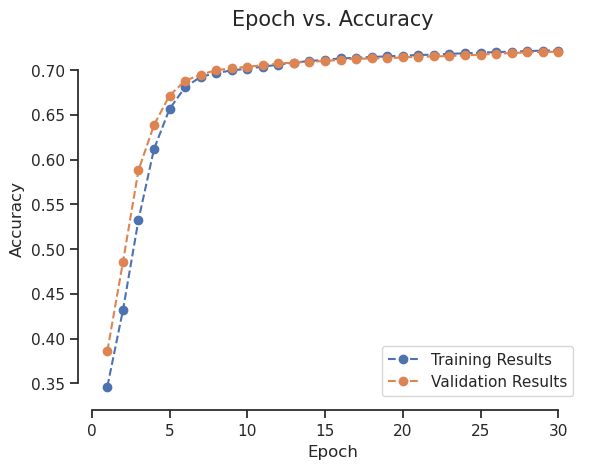

In [55]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

In [56]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # input 
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            # hidden 
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
            # output 
            nn.Linear(input_dim // 4, output_dim)
        )
      
    def forward(self, x):
        """ Defines the computation performed at every call. """
        return self.network(x)


In [57]:
## TODO : define model, optimiser, cross entropy loss,
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr=0.001
model_2 = TabularNetwork(input_dim, output_dim).to(device)

# Define the loss function
loss_2 = torch.nn.CrossEntropyLoss()

# Define the optimizer, you can play around with the learning rate and weight decay parameters
optim = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.005)

#  model to train mode
model_2.train()

TabularNetwork(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=7, bias=True)
    (3): ReLU()
    (4): Linear(in_features=7, out_features=3, bias=True)
  )
)

In [58]:
## TODO : Train model
num_epochs = 50

train_losses, val_losses, train_accs, val_accs = run_training(model_2, optim, loss_2, device, num_epochs, train_dataloader =train_loader, val_dataloader=val_loader)

Finished training after 133 seconds.


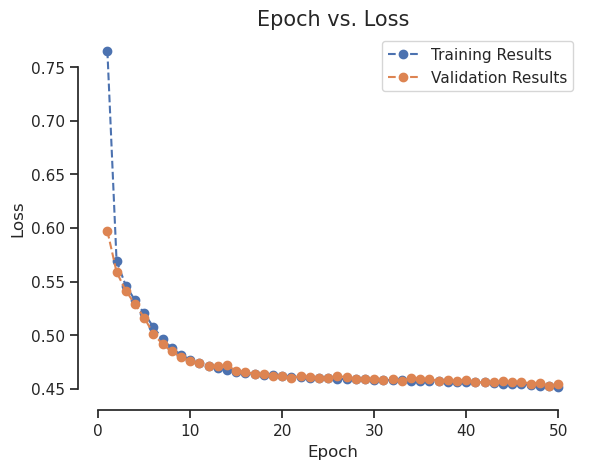

In [59]:
# TODO plot losses
plot('Epoch vs. Loss', 'Loss', train_losses, val_losses)

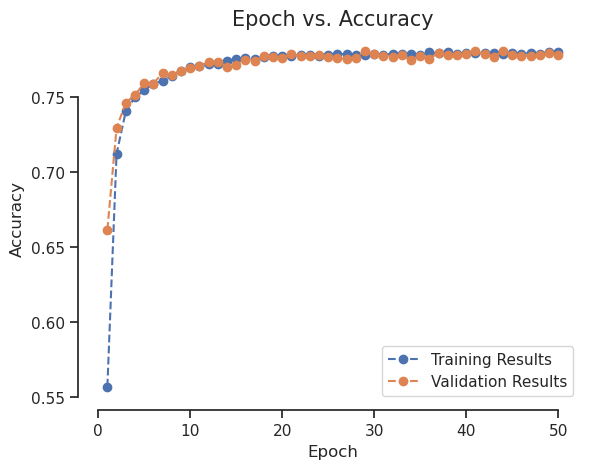

In [60]:
# TODO plot accuracies
plot('Epoch vs. Accuracy', 'Accuracy', train_accs, val_accs)

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?
- Almost Same: Complexity of the problem:  Task is not very complex (i.e., the relationship between inputs and outputs is relatively straightforward), both models might be enough to solve it. More complex and non-linear tasks might show more significant differences in performance.

## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/